<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-Finance/blob/master/StockPrediction_basicRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted by Carlos Toxtli http://www.carlostoxtli.com/#colab-stock-1

Credits: https://github.com/Kulbear/stock-prediction

In [1]:
!git clone https://github.com/Kulbear/stock-prediction
%cd stock-prediction

Cloning into 'stock-prediction'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (34/34), done.
/content/stock-prediction


# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [2]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

## Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [3]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [4]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [5]:
def recover_scaler(train_orig, test_orig, X_train, X_test, predictions_for_inverse_transform):

    train_orig_samples, train_orig_nx, train_orig_ny = train_orig.shape
    
    train_orig = train_orig.reshape((train_orig_samples, train_orig_nx * train_orig_ny))

    preprocessor = prep.StandardScaler().fit(train_orig)


    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    predictions_for_inverse_transform_samples, predictions_for_inverse_transform_nx, predictions_for_inverse_transform_ny = predictions_for_inverse_transform.shape
    
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    predictions_for_inverse_transform = predictions_for_inverse_transform.reshape((predictions_for_inverse_transform_samples, predictions_for_inverse_transform_nx * predictions_for_inverse_transform_ny))
    
    # print (X_test)
    # print (predictions_for_inverse_transform)

    X_train = preprocessor.inverse_transform(X_train)
    X_test = preprocessor.inverse_transform(X_test)
    predictions_for_inverse_transform = preprocessor.inverse_transform(predictions_for_inverse_transform)    

    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    predictions_for_inverse_transform = predictions_for_inverse_transform.reshape((predictions_for_inverse_transform_samples, predictions_for_inverse_transform_nx, predictions_for_inverse_transform_ny))

    return X_train, X_test, predictions_for_inverse_transform

Split the data to X_train, y_train, X_test, y_test

In [6]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    ## Probably here add another column as the label.
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])

        # print (index)

        # print (result)
    
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]

    print (train)
    print (result)
    # # print (row)
    # print ("X_train")
    # print (train[:, : -1])
    # print ("y_train")
    # print (train[:, -1][: ,-1]) 

    # print ("X_test")
    # print (result[int(row) :, : -1]) 
    # print ("y_test")
    print (result[int(row) :, -1][ : ,-1]) 

    # trainFit = StandardScaler().fit(train)
    # resultFit = StandardScaler().fit(result)
    # train = trainFit.transform(train)
    # result = resultFit.transform(result)

    train_standard, result_standard = standard_scaler(train, result)

    
    X_train = train_standard[:, : -1]
    y_train = train_standard[:, -1][: ,-1]
    X_test = result_standard[int(row) :, : -1]
    y_test = result_standard[int(row) :, -1][ : ,-1]

    print (y_test)



    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 

 

    return [X_train, y_train, X_test, y_test, train, result,train_standard,result_standard]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [7]:
def build_model(layers):

    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation='linear'))

    start = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary() 
    print("Compilation Time : ", time.time() - start)
    return model

In [8]:
window = 20
X_train, y_train, X_test, y_test, train_orig, result_orig, train_for_inverse_transform,result_for_inverse_transform = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# print (X_train)
# print (y_train)
# print (X_test)
# print (y_test)

[[[6.03000000e+00 6.19000000e+00 5.85000000e+00 3.78800000e+05
   2.28317000e+06 6.17000000e+00]
  [6.20000000e+00 6.31000000e+00 6.06000000e+00 5.44600000e+05
   3.38570500e+06 6.26000000e+00]
  [6.26000000e+00 6.35000000e+00 6.12000000e+00 5.60400000e+05
   3.49940500e+06 6.15000000e+00]
  ...
  [5.55000000e+00 5.62000000e+00 5.50000000e+00 1.50900000e+05
   8.41633000e+05 5.57000000e+00]
  [5.50000000e+00 5.60000000e+00 5.45000000e+00 1.57300000e+05
   8.70136000e+05 5.55000000e+00]
  [5.60000000e+00 5.61000000e+00 5.52000000e+00 8.88000000e+04
   4.94768000e+05 5.56000000e+00]]

 [[6.20000000e+00 6.31000000e+00 6.06000000e+00 5.44600000e+05
   3.38570500e+06 6.26000000e+00]
  [6.26000000e+00 6.35000000e+00 6.12000000e+00 5.60400000e+05
   3.49940500e+06 6.15000000e+00]
  [6.08000000e+00 6.18000000e+00 6.02000000e+00 4.62600000e+05
   2.82735100e+06 6.18000000e+00]
  ...
  [5.50000000e+00 5.60000000e+00 5.45000000e+00 1.57300000e+05
   8.70136000e+05 5.55000000e+00]
  [5.60000000e+0

In [9]:
model = build_model([X_train.shape[2], window, 100, 1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 512)           1062912   
_________________________________________________________________
dropout (Dropout)            (None, 20, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 64)            4

## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [10]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=200,
    validation_split=0.1,
    verbose=0)

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.08 RMSE)
Test Score: 0.03 MSE (0.17 RMSE)


## Visualize the Prediction

In [12]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [13]:
# TODO: Scale it back

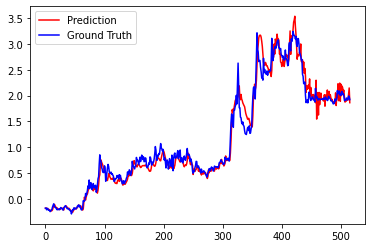

In [14]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2


plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

b
[ 9.38  9.4   9.21  9.33  9.35  9.16  9.16  9.16  9.02  9.12  9.17  9.25
  9.5   9.67  9.83  9.62  9.46  9.44  9.44  9.25  9.21  9.27  9.23  9.28
  9.22  9.33  9.44  9.39  9.33  9.22  9.18  9.44  9.47  9.57  9.64  9.51
  9.41  9.31  9.35  9.35  9.22  9.2   9.1   9.09  8.78  9.02  9.22  9.18
  9.4   9.3   9.39  9.29  9.33  9.4   9.58  9.6   9.71  9.51  9.67  9.47
  9.29  9.19  9.24  9.37 10.15 10.08 10.1  10.27 10.9  10.64 10.93 11.2
 11.69 11.46 12.3  11.42 11.95 12.03 11.69 11.3  11.53 11.93 11.62 11.48
 11.72 11.75 11.03 11.22 11.78 12.43 12.64 13.9  14.91 14.36 14.23 13.59
 13.45 13.12 13.07 13.1  13.77 13.52 12.17 12.35 13.05 13.58 13.92 13.7
 13.18 13.   13.01 13.12 12.88 12.96 12.8  12.7  12.16 12.18 12.42 12.41
 12.47 12.76 12.64 12.77 12.4  12.85 12.75 12.77 12.2  12.22 11.9  11.94
 12.22 12.02 11.93 12.22 12.23 12.49 12.63 13.14 12.87 13.14 13.36 13.05
 12.78 12.95 13.35 14.24 13.82 13.72 13.59 13.45 13.72 13.82 14.64 14.32
 14.37 14.12 13.9  14.3  14.67 14.21 14.48 14.88 14

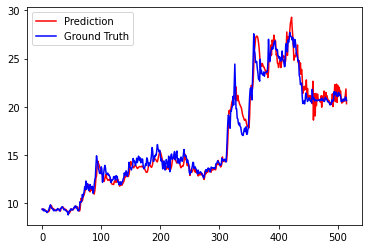

In [15]:

row = round(0.9 * result_for_inverse_transform.shape[0])
# print (result_for_inverse_transform[int(row) :, -1][ : ,-1])
import copy

predictions_for_inverse_transform = copy.deepcopy(result_for_inverse_transform)

#print (pred)
for i in range(len(pred)):
  predictions_for_inverse_transform[int(row) :, -1][ i ,-1] = pred[i]

# print (predictions_for_inverse_transform[int(row) :, -1][ : ,-1])

a,b,c =  recover_scaler(train_orig, result_orig, train_for_inverse_transform, result_for_inverse_transform, predictions_for_inverse_transform)
recovered_stock_true_price = b[int(row) :, -1][ : ,-1]
recovered_stock_pred_price = c[int(row) :, -1][ : ,-1]
# print (result_orig[int(row) :, -1][ : ,-1])
print ("b")
print (b[int(row) :, -1][ : ,-1])
print ("c")
print (c[int(row) :, -1][ : ,-1])

plt2.plot(recovered_stock_pred_price, color='red', label='Prediction')
plt2.plot(recovered_stock_true_price, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

turtle-agent

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
from pandas import DataFrame
df = DataFrame (recovered_stock_true_price,columns=['Close'])
print (df)

     Close
0     9.38
1     9.40
2     9.21
3     9.33
4     9.35
..     ...
511  20.60
512  20.70
513  21.02
514  20.94
515  20.64

[516 rows x 1 columns]


In [18]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,9.380000,9.3800,NaN
1,0.0,9.390000,9.3900,0.0
2,0.0,9.330000,9.3300,0.0
3,0.0,9.330000,9.3300,0.0
4,0.0,9.334000,9.3340,0.0
...,...,...,...,...
511,1.0,20.947500,20.9028,0.0
512,0.0,20.916667,20.9228,-1.0
513,0.0,20.880833,20.9548,0.0
514,0.0,20.835000,20.9820,0.0


In [19]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 10,
    max_sell = 10,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [20]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 15: buy 10 units at price 96.200000, total balance 9903.800000
day 27, sell 10 units at price 93.900000, investment -2.390852 %, total balance 9997.700000,
day 37: buy 10 units at price 93.100000, total balance 9904.600000
day 44, sell 10 units at price 87.800000, investment -5.692803 %, total balance 9992.400000,
day 56: buy 10 units at price 97.100000, total balance 9895.300000
day 111, sell 10 units at price 131.200000, investment 35.118435 %, total balance 10026.500000,
day 142: buy 10 units at price 133.600000, total balance 9892.900000
day 175, sell 10 units at price 140.700000, investment 5.314371 %, total balance 10033.600000,
day 186: buy 10 units at price 157.700000, total balance 9875.900000
day 207, sell 10 units at price 142.000000, investment -9.955612 %, total balance 10017.900000,
day 222: buy 10 units at price 147.000000, total balance 9870.900000
day 237, sell 10 units at price 143.400000, investment -2.448980 %, total balance 10014.300000,
day 244: buy 10 units a

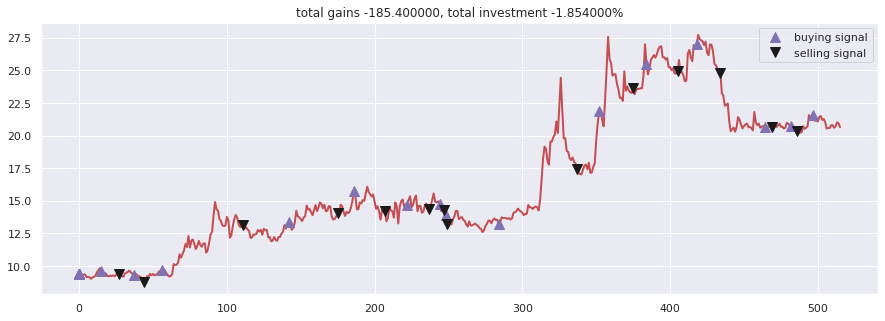

In [21]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()